## 결정 트리 실습 - 사용자 행동 인식 데이터 세트

  * 사용자 행동 인식 데이터세트
    * 30명에게 스마트폰 센서를 장착한 뒤 사람의 동작과 관련된 여러 가지 피처를 수집한 데이터
      * 피처 세트를 기반으로 결정 트리를 이용해 어떠한 동작인지 예측

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드
feature_name_df=pd.read_csv('features.txt',sep='\s+', header=None, names=['column_index','column_name'])

#피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name=feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [5]:
#중복된 피처명 확인
feature_dup_df=feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [8]:
#중복된 피처명 변경
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df=pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
  feature_dup_df=feature_dup_df.reset_index()
  new_feature_name_df=pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')
  new_feature_name_df['column_name']=new_feature_name_df[['column_name','dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1]) if x[1]>0 else x[0],axis=1)
  new_feature_name_df=new_feature_name_df.drop(['index'],axis=1)
  return new_feature_name_df

In [9]:
import pandas as pd
def get_human_dataset():
  #각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백문자를 sep으로 할당
  feature_name_df=pd.read_csv('features.txt',sep='\s+', header=None, names=['column_index','column_name'])

  #중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame을 생성
  new_feature_name_df=get_new_feature_name_df(feature_name_df)

  #DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
  feature_name = new_feature_name_df.iloc[:,1].values.tolist()

  #학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
  X_train=pd.read_csv('X_train.txt', sep='\s+', names=feature_name)
  X_test=pd.read_csv('X_test.txt',sep='\s+',names=feature_name)

  #학습 레이블과 테스트 레이블 데이터를 DataFrame 으로 로딩하고 칼럼명은 action으로 부여
  y_train=pd.read_csv('y_train.txt', sep='\s+', header=None, names=['action'])
  y_test=pd.read_csv('y_test.txt',sep='\s+',header=None, names=['action'])

  #로드된 학습/테스트용 DataFrame을 모두 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test=get_human_dataset()



In [10]:
#로드한 학습용 피처 데이터 확인
print('##학습 피처 데이터 셋 info()')
print(X_train.info())

##학습 피처 데이터 셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


> 7352개의 레코드로 561개의 피처
> 피처 전부 float

In [11]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


* 사이킷런의 DecisionTreeClassifier를 이용해 동작 예측 분류를 수행

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#예제 반복시마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf=DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred=dt_clf.predict(X_test)
accuracy=accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

#DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


* 결정트리의 트리 깊이가 예측 정확도에 주는 영향 살펴보기
  * GridSearchCV를 이용해 사이킷런 결정트리의 깊이를 조절할 수 있는 하이퍼 파라미터인 max_depth 값을 변화시키면서 예측 성능을 확인

In [13]:
from sklearn.model_selection import GridSearchCV

params={
    'max_depth' : [6,8,10,12,16,20,24]
}

grid_cv=GridSearchCV(dt_clf,param_grid=params,scoring='accuracy',cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:',grid_cv.best_params_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치:0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


* max_depth값에 따라 예측 성능이 어떻게 변했는지 GridSearchCV 객체의 cv_results_ 을 통해 알아보기 

In [15]:
#GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성
cv_results_df=pd.DataFrame(grid_cv.cv_results_)

#max_depth 파라미터 값과 그때의 테스트 세트, 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth','mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


> mean_test_score : 5개 CV 세트에서 검증용 데이터 세트의 정확도 평균 수치

* 깊어진 트리는 과적합으로 인해 성능이 떨어질 수 있음

In [16]:
#별도의 test데이터 세트에서 max_depth 변화에 따른 값 측정
max_depths=[6,8,10,12,16,20,24]

#max_depth 값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depths:
  dt_clf=DecisionTreeClassifier(max_depth=depth, random_state=156)
  dt_clf.fit(X_train, y_train)
  pred=dt_clf.predict(X_test)
  accuracy=accuracy_score(y_test,pred)
  print('max_depth={0} 정확도 : {1:.4f}'.format(depth,accuracy))

max_depth=6 정확도 : 0.8558
max_depth=8 정확도 : 0.8707
max_depth=10 정확도 : 0.8673
max_depth=12 정확도 : 0.8646
max_depth=16 정확도 : 0.8575
max_depth=20 정확도 : 0.8548
max_depth=24 정확도 : 0.8548


* max_depth와 min_sample_split을 같이 변경하면서 예측 정확도 성능을 튜닝


In [19]:
params={'max_depth':[8,12,16,20],
        'min_samples_split':[16,24]}

grid_cv=GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))  
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)     

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치:0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


> max_depth가 8, min_sampels_split이 16일 때 최고의 정확도

* 별도 분리된 테스트 데이터 세트에 해당 하이퍼 파라미터를 적용
  * GridSearchCV 객체의 best_estimator_에는 최적 하이퍼 파라미터인 max_depth와 min_split으로 학습이 완료된 Estimator 객체


In [18]:
best_df_clf=grid_cv.best_estimator_
pred1=best_df_clf.predict(X_test)
accuracy=accuracy_score(y_test,pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.8717


* features_importance_ 속성으로 결정 트리에서 각 피처의 중요도 알아보기
  * 중요도가 높은 순으로 Top 20 피처를 막대그래프로 표현

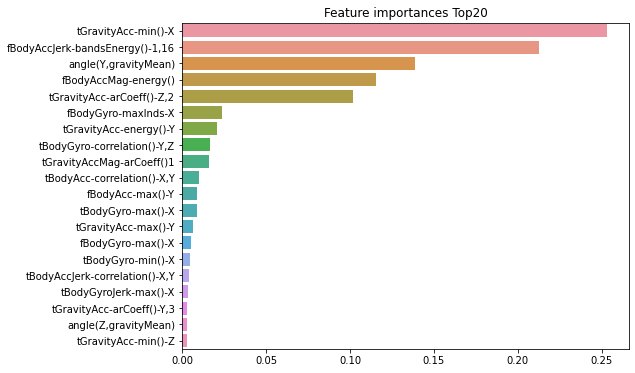

In [24]:
import seaborn as sns

ftr_importances_values=best_df_clf.feature_importances_
#Top 중요도로 정렬을 쉽게 하고, 시본의 막대 그래프로 쉽게 표현하기 위해 Series 변환
ftr_importances=pd.Series(ftr_importances_values,index=X_train.columns )
#중요도 값 순으로 Series를 정렬
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top20')
sns.barplot(x=ftr_top20,y=ftr_top20.index)
plt.show()

> Top5의 피처들이 매우 중요하게 규칙 생성에 영향을 미침